K-means is a clustering algorithm that groups data points into K distinct clusters based on their similarity. It is an unsupervised learning technique that is widely used in data mining, machine learning, and pattern recognition. The algorithm works by iteratively assigning data points to a cluster based on their distance from the cluster’s centroid and then recomputing the centroid of each cluster. The process continues until the clusters’ centroids converge or a maximum number of iterations is reached. K-means is simple, efficient, and effective in finding the optimal clusters for a given dataset, making it a popular choice for various applications.

In [1]:
import findspark 
findspark.init()

#### Step 1: Starting the PySpark server 

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()
print('Spark Version: {}'.format(spark.version))


Spark Version: 3.4.0


#### Step 2: Load the dataset

In [8]:
#Loading the data
dataset = spark.read.csv("seeds_dataset.csv",header=True,inferSchema=True)

#show the data in the above file using the below command
dataset.show(5)

+-----+---------+-----------+----------------+---------------+---------------------+----------------+
| area|perimeter|compactness|length_of_kernel|width_of_kernel|asymmetry_coefficient|length_of_groove|
+-----+---------+-----------+----------------+---------------+---------------------+----------------+
|15.26|    14.84|      0.871|           5.763|          3.312|                2.221|            5.22|
|14.88|    14.57|     0.8811|           5.554|          3.333|                1.018|           4.956|
|14.29|    14.09|      0.905|           5.291|          3.337|                2.699|           4.825|
|13.84|    13.94|     0.8955|           5.324|          3.379|                2.259|           4.805|
|16.14|    14.99|     0.9034|           5.658|          3.562|                1.355|           5.175|
+-----+---------+-----------+----------------+---------------+---------------------+----------------+
only showing top 5 rows



In [9]:
#Print schema
dataset.printSchema()


root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_of_kernel: double (nullable = true)
 |-- width_of_kernel: double (nullable = true)
 |-- asymmetry_coefficient: double (nullable = true)
 |-- length_of_groove: double (nullable = true)



#### Step 3:  Format the data using Vector Assembler into vectors which will be used as “features”

In [10]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols = dataset.columns,outputCol='features')

final_data = vec_assembler.transform(dataset)
final_data.select('features').show(5)


+--------------------+
|            features|
+--------------------+
|[15.26,14.84,0.87...|
|[14.88,14.57,0.88...|
|[14.29,14.09,0.90...|
|[13.84,13.94,0.89...|
|[16.14,14.99,0.90...|
+--------------------+
only showing top 5 rows



#### Step 4: Scaling the data
It is a good idea to scale our data to deal with the curse of dimensionality.

In [11]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features",
						outputCol="scaledFeatures",
						withStd=True,
						withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

final_data.select('scaledFeatures').show(5)


+--------------------+
|      scaledFeatures|
+--------------------+
|[5.24452795332028...|
|[5.11393027165175...|
|[4.91116018695588...|
|[4.75650503761158...|
|[5.54696468981581...|
+--------------------+
only showing top 5 rows



#### Step 5: Find the number of clusters using Silhouette Score


In [12]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
								featuresCol='scaledFeatures', \
								metricName='silhouette',
								distanceMeasure='squaredEuclidean')

for i in range(2,10):
	kmeans=KMeans(featuresCol='scaledFeatures', k=i)
	model=kmeans.fit(final_data)
	predictions=model.transform(final_data)
	score=evaluator.evaluate(predictions)
	silhouette_score.append(score)
	print('Silhouette Score for k =',i,'is',score)


Silhouette Score for k = 2 is 0.6650046474811556
Silhouette Score for k = 3 is 0.5928460631863646
Silhouette Score for k = 4 is 0.5060495150647687
Silhouette Score for k = 5 is 0.3928017058363138
Silhouette Score for k = 6 is 0.4007359770746202
Silhouette Score for k = 7 is 0.38009284203416843
Silhouette Score for k = 8 is 0.3811053807547592
Silhouette Score for k = 9 is 0.3911474215224909


#### Plot the Silhouette Score graph


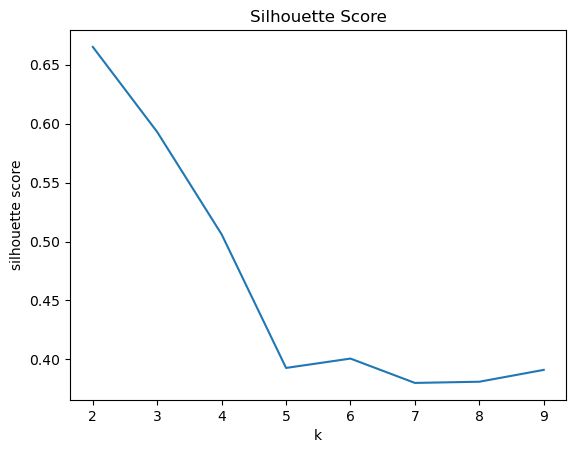

In [13]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()


Since there is no definitive answer as to what value of K is an acceptable value. I want to move forward with k = 3 Where a local maximum of Silhouette Score is detected.

#### Step 6: Train the Model


In [14]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)


#### Print cluster centers


In [15]:
# Printing cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
	print(center)


Cluster Centers: 
[ 4.07497225 10.14410142 35.89816849 11.80812742  7.54416916  3.15410901
 10.38031464]
[ 4.96198582 10.97871333 37.30930808 12.44647267  8.62880781  1.80061978
 10.41913733]
[ 6.35645488 12.40730852 37.41990178 13.93860446  9.7892399   2.41585013
 12.29286107]


In [16]:
predictions.select('prediction').show(5)


+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
+----------+
only showing top 5 rows



In [17]:
#End Session
spark.stop()
